In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.neighbors import NearestNeighbors



In [3]:
sns.set(style="whitegrid")
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

**Load data**

In [4]:
def load_data(path="all_upwork_jobs.csv"):
    if os.path.exists(path):
        print(f"Loading dataset from {path}")
        df = pd.read_csv(path, encoding="latin1", on_bad_lines="skip")
    else:
        print("No CSV found. Creating a small demo dataset.")
        np.random.seed(42)
        titles = ["Data Engineer","Full Stack Developer","SEO Specialist","SMMA Bubble App","Talent Hunter","Media Buyer"]
        countries = ["United States","India","Portugal","United Kingdom","Canada"]
        rows = []
        for i in range(200):
            title = np.random.choice(titles)
            is_hourly = np.random.rand() < 0.5
            if is_hourly:
                low = round(np.random.uniform(8,30),2)
                high = round(low + np.random.uniform(0,25),2)
                budget = np.nan
            else:
                low = np.nan
                high = np.nan
                budget = int(np.random.uniform(150,5000))
            rows.append({
                "title": title,
                "link": f"https://example.com/job/{i}",
                "published_date": pd.Timestamp("2024-02-17") + pd.to_timedelta(np.random.randint(0,200),'D'),
                "is_hourly": is_hourly,
                "hourly_low": low,
                "hourly_high": high,
                "budget": budget,
                "country": np.random.choice(countries)
            })
        df = pd.DataFrame(rows)

**Cleaning & feature engineering**

In [5]:
def load_data(path="all_upwork_jobs.csv"):
    if os.path.exists(path):
        print(f"Loading dataset from {path}")
        df = pd.read_csv(path, encoding="latin1", on_bad_lines="skip")
    else:
        print("No CSV found. Creating a small demo dataset.")
        np.random.seed(42)
        titles = ["Data Engineer","Full Stack Developer","SEO Specialist","SMMA Bubble App","Talent Hunter","Media Buyer"]
        countries = ["United States","India","Portugal","United Kingdom","Canada"]
        rows = []
        for i in range(200):
            title = np.random.choice(titles)
            is_hourly = np.random.rand() < 0.5
            if is_hourly:
                low = round(np.random.uniform(8,30),2)
                high = round(low + np.random.uniform(0,25),2)
                budget = np.nan
            else:
                low = np.nan
                high = np.nan
                budget = int(np.random.uniform(150,5000))
            rows.append({
                "title": title,
                "link": f"https://example.com/job/{i}",
                "published_date": pd.Timestamp("2024-02-17") + pd.to_timedelta(np.random.randint(0,200),'D'),
                "is_hourly": is_hourly,
                "hourly_low": low,
                "hourly_high": high,
                "budget": budget,
                "country": np.random.choice(countries)
            })
        df = pd.DataFrame(rows)

    # Clean columns
    df.columns = [c.strip() for c in df.columns]
    for c in ["hourly_low","hourly_high","budget"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "published_date" in df.columns:
        df["published_date"] = pd.to_datetime(df["published_date"], errors="coerce")

    # Compute average hourly rate
    df["avg_hourly"] = df[["hourly_low","hourly_high"]].mean(axis=1)
    df["hourly_monthly"] = df["avg_hourly"] * 160  # 40 hours/week * 4 weeks

    # Compute effective salary
    df["effective_salary"] = df.apply(
        lambda r: r["hourly_monthly"] if (pd.notna(r.get("hourly_monthly")) and r.get("is_hourly", False))
        else r.get("budget", np.nan),
        axis=1
    )
    return df

df = load_data()
print("\nData shape:", df.shape)
print("Missing values per column:\n", df.isna().sum())


Loading dataset from all_upwork_jobs.csv

Data shape: (244827, 11)
Missing values per column:
 title                    1
link                     1
published_date         178
is_hourly              115
hourly_low          142411
hourly_high         146023
budget              141024
country               5248
avg_hourly          142323
hourly_monthly      142323
effective_salary     38520
dtype: int64


**EDA & Visualization**

In [6]:
# Top job titles
top_titles = df["title"].value_counts().head(8)
print("\nTop job titles:\n", top_titles)

# Top countries
top_countries = df["country"].value_counts().head(8)
print("\nTop countries:\n", top_countries)

# Salary stats
salary_stats = df["effective_salary"].dropna().describe().round(2)
print("\nEffective salary stats:\n", salary_stats)

# Median & mean
median_salary = salary_stats["50%"]
mean_salary = salary_stats["mean"]
print(f"\nINSIGHT: median = {median_salary}, mean = {mean_salary}")



Top job titles:
 title
Social Media Manager    419
Virtual Assistant       339
Logo Design             311
Video Editor            298
Graphic Designer        292
Logo design             173
Logo Designer           142
Full Stack Developer    136
Name: count, dtype: int64

Top countries:
 country
United States     99765
United Kingdom    19129
India             15833
Australia         12611
Canada            11648
Pakistan           5291
Germany            4844
Netherlands        4432
Name: count, dtype: int64

Effective salary stats:
 count     206307.00
mean        2799.96
std        12543.44
min            5.00
25%          100.00
50%         1000.00
75%         3760.00
max      1600000.00
Name: effective_salary, dtype: float64

INSIGHT: median = 1000.0, mean = 2799.96


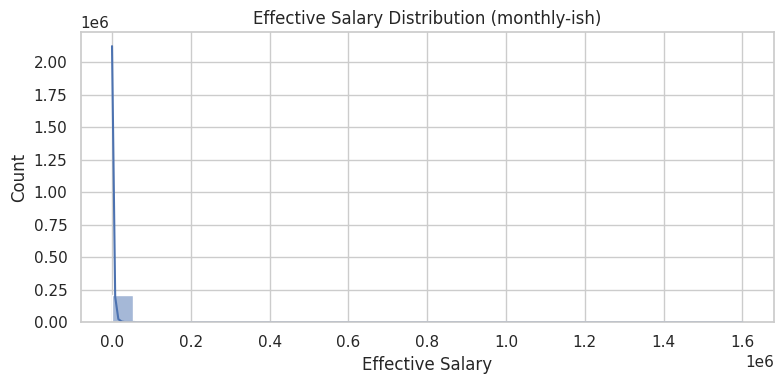

In [7]:
# Salary distribution
plt.figure(figsize=(8,4))
sns.histplot(df["effective_salary"].dropna(), bins=30, kde=True)
plt.title("Effective Salary Distribution (monthly-ish)")
plt.xlabel("Effective Salary")
plt.tight_layout()
plt.show()

In [8]:
# Top countries
top_countries = df["country"].value_counts().head(8)
print("\nTop countries by job count:\n", top_countries)


Top countries by job count:
 country
United States     99765
United Kingdom    19129
India             15833
Australia         12611
Canada            11648
Pakistan           5291
Germany            4844
Netherlands        4432
Name: count, dtype: int64


In [9]:
# Salary stats
salary_stats = df["effective_salary"].dropna().describe().round(2)
print("\nEffective salary (monthly-ish) stats:\n", salary_stats)


Effective salary (monthly-ish) stats:
 count     206307.00
mean        2799.96
std        12543.44
min            5.00
25%          100.00
50%         1000.00
75%         3760.00
max      1600000.00
Name: effective_salary, dtype: float64


In [10]:
# Highest paying job(s)
if df["effective_salary"].dropna().size > 0:
    idx_max = df["effective_salary"].idxmax()
    row_max = df.loc[idx_max]
    print("\nHIGHEST PAYING JOB:")
    print(f" Title: {row_max['title']}")
    print(f" Country: {row_max.get('country','')}")
    print(f" Effective salary: {row_max['effective_salary']}")


HIGHEST PAYING JOB:
 Title: ??·???MAIL MARKETERS, DESIGNERS, AND SMS WIZARDS ???????????·??????????·?
??·???e Are Hiring at SCALE ALCHEMY??·??·,https://www.upwork.com/jobs/EMAIL-MARKETERS-DESIGNERS-AND-SMS-WIZARDS-Are-Hiring-SCALE-ALCHEMY_%7E01c421c23fdd7f412f?source=rss"
 Country: nan
 Effective salary: 1600000.0


In [11]:
import pandas as pd

# Load your dataset (change path if needed)
df = pd.read_csv("all_upwork_jobs.csv", encoding="latin1", on_bad_lines="skip")

print("Data loaded:", df.shape)
print(df.head())

Data loaded: (244827, 8)
                                               title  \
0  Experienced Media Buyer For Solar Pannel and R...   
1                               Full Stack Developer   
2                                    SMMA Bubble App   
3             Talent Hunter Specialized in Marketing   
4                                      Data Engineer   

                                                link  \
0  https://www.upwork.com/jobs/Experienced-Media-...   
1  https://www.upwork.com/jobs/Full-Stack-Develop...   
2  https://www.upwork.com/jobs/SMMA-Bubble-App_%7...   
3  https://www.upwork.com/jobs/Talent-Hunter-Spec...   
4  https://www.upwork.com/jobs/Data-Engineer_%7E0...   

              published_date is_hourly  hourly_low  hourly_high budget  \
0  2024-02-17 09:09:54+00:00     FALSE         NaN          NaN    500   
1  2024-02-17 09:09:17+00:00     FALSE         NaN          NaN   1100   
2  2024-02-17 09:08:46+00:00      TRUE        10.0         30.0    NaN   
3  20

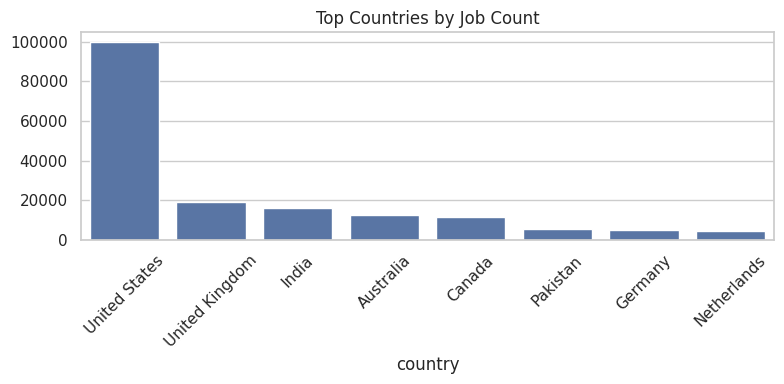

In [12]:
# Top countries by job count
plt.figure(figsize=(8,4))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top Countries by Job Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**TF-IDF Keyword Extraction**

In [13]:
df["text"] = df["title"].fillna("") + " " + df["country"].fillna("")
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(df["text"])

# Top keywords
tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).ravel()
feature_names = vectorizer.get_feature_names_out()
top_n = min(15, len(feature_names))
top_idx = tfidf_sum.argsort()[::-1][:top_n]

print("\nTop TF-IDF Keywords:")
for i in top_idx:
    print(f" {feature_names[i]} ({tfidf_sum[i]:.2f})")



Top TF-IDF Keywords:
 united (16114.04)
 states (14841.51)
 kingdom (5139.10)
 website (5006.10)
 india (4771.97)
 developer (4745.30)
 needed (4406.03)
 expert (4251.53)
 video (4217.72)
 design (4096.86)
 designer (4082.69)
 australia (3829.09)
 canada (3640.30)
 specialist (3024.75)
 marketing (2906.51)


In [15]:
# Ensure numeric
for c in ["hourly_low","hourly_high","budget"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Average hourly
df["avg_hourly"] = df[["hourly_low","hourly_high"]].mean(axis=1)

# Approximate monthly from hourly
df["hourly_monthly"] = df["avg_hourly"] * 160

# Effective salary: use hourly_monthly if hourly, else budget
df["effective_salary"] = df.apply(
    lambda r: r["hourly_monthly"] if (pd.notna(r.get("hourly_monthly")) and r.get("is_hourly", False))
    else r.get("budget", np.nan),
    axis=1
)


**Job Recommendation System**

In [17]:
# Reduce dimensionality for NearestNeighbors
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Fit NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, metric="cosine")
nn_model.fit(X_reduced)

# Function to recommend similar jobs
def recommend_jobs(job_idx, n=5):
    distances, indices = nn_model.kneighbors([X_reduced[job_idx]], n_neighbors=n)
    print(f"\nRecommendations for job: {df.iloc[job_idx]['title']} ({df.iloc[job_idx]['country']})")
    for i, idx in enumerate(indices[0]):
        if idx != job_idx:
            salary = df.iloc[idx].get('effective_salary', 'N/A')
            print(f"{i+1}. {df.iloc[idx]['title']} ({df.iloc[idx]['country']}) - Salary: {salary}")

# Example usage
recommend_jobs(0)


Recommendations for job: Experienced Media Buyer For Solar Pannel and Roofing installation companies. (nan)
2. Experienced  TikTok Media Buyer (Israel) - Salary: nan
3. Busco Media Buyer con Experiencia en E-Commerce (Chile) - Salary: 300.0
4. Busco Media Buyer para Ecommerce (Argentina) - Salary: 200.0
5. Media Buyer Contractors, Roofers, Remodeling (Latvia) - Salary: nan


**Save Your Model for Deployment**

In [18]:
import joblib
import os

MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(vectorizer, os.path.join(MODEL_DIR, "tfidf_vectorizer.pkl"))
joblib.dump(svd, os.path.join(MODEL_DIR, "svd_model.pkl"))
joblib.dump(nn_model, os.path.join(MODEL_DIR, "nn_model.pkl"))
print("Models saved successfully!")


Models saved successfully!


**Create a Web API with Flask**

In [35]:
from pyngrok import ngrok

# Kill all existing tunnels
ngrok.kill()
print("All ngrok tunnels closed.")


All ngrok tunnels closed.


In [ ]:
# ----------------------------
# Install dependencies (Colab only)
# ----------------------------
!pip install flask pyngrok joblib --quiet

# ----------------------------
# Imports
# ----------------------------
from flask import Flask, request, jsonify, render_template_string
from pyngrok import ngrok
import pandas as pd
import joblib
import numpy as np

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv("all_upwork_jobs.csv", encoding="latin1", on_bad_lines="skip")

# Preprocess salaries
for c in ["hourly_low", "hourly_high", "budget"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["avg_hourly"] = df[["hourly_low", "hourly_high"]].mean(axis=1)
df["hourly_monthly"] = df["avg_hourly"] * 160
df["effective_salary"] = df.apply(
    lambda r: r["hourly_monthly"] if pd.notna(r.get("hourly_monthly")) and r.get("is_hourly", False)
    else r.get("budget", 0),
    axis=1
)
df["text"] = df["title"].fillna("") + " " + df["country"].fillna("")

# ----------------------------
# Load trained models
# ----------------------------
vectorizer = joblib.load("./models/tfidf_vectorizer.pkl")
svd = joblib.load("./models/svd_model.pkl")
nn_model = joblib.load("./models/nn_model.pkl")

X_tfidf = vectorizer.transform(df["text"])
X_reduced = svd.transform(X_tfidf)

# ----------------------------
# Flask app
# ----------------------------
app = Flask(__name__)

@app.route("/", methods=["GET"])
def home():
    return "Recommendation API is running! Use /recommend to see job recommendations."

@app.route("/recommend", methods=["GET", "POST"])
def recommend():
    # Read inputs from form or query params
    if request.method == "POST":
        job_idx = int(request.form.get("job_index", 0))
        n = int(request.form.get("n", 5))
    else:  # GET
        job_idx = int(request.args.get("job_index", 0))
        n = int(request.args.get("n", 5))

    # Get neighbors
    distances, indices = nn_model.kneighbors([X_reduced[job_idx]], n_neighbors=n)
    recommendations = []
    for idx in indices[0]:
        if idx != job_idx:
            salary = df.iloc[idx]["effective_salary"]
            if salary > 0:
                recommendations.append({
                    "title": df.iloc[idx]["title"],
                    "country": df.iloc[idx]["country"],
                    "effective_salary": float(salary)
                })

    # HTML form + results table
    html_template = """
    <html>
    <head>
        <title>Job Recommendations</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 40px; }
            form { text-align: center; margin-bottom: 30px; }
            input, button { padding: 8px; margin: 5px; }
            table { border-collapse: collapse; width: 80%; margin: auto; }
            th, td { border: 1px solid #ddd; padding: 10px; text-align: center; }
            th { background-color: #4CAF50; color: white; }
            tr:nth-child(even) { background-color: #f2f2f2; }
        </style>
    </head>
    <body>
        <h2 style="text-align:center;">Job Recommendations</h2>

        <form method="post">
            <label>Job Index:</label>
            <input type="number" name="job_index" value="{{ job_idx }}" min="0">
            <label>Number of Recommendations:</label>
            <input type="number" name="n" value="{{ n }}" min="1" max="20">
            <button type="submit">Get Recommendations</button>
        </form>

        <table>
            <tr>
                <th>Title</th>
                <th>Country</th>
                <th>Effective Salary</th>
            </tr>
            {% for rec in recommendations %}
            <tr>
                <td>{{ rec.title }}</td>
                <td>{{ rec.country }}</td>
                <td>{{ rec.effective_salary }}</td>
            </tr>
            {% endfor %}
        </table>
    </body>
    </html>
    """

    return render_template_string(html_template, recommendations=recommendations, job_idx=job_idx, n=n)

# ----------------------------
# Start ngrok tunnel
# ----------------------------
NGROK_AUTH_TOKEN = "30WMYAsA1jiKQqsxhjzDBd6oamD_3jXCRjDbLja2dravFoxsY"  # replace with your ngrok token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

import random
PORT = random.randint(5000, 9000)
public_url = ngrok.connect(PORT)
print(" * Public URL:", public_url)

# Run Flask app
app.run(port=PORT)


 * Public URL: NgrokTunnel: "https://c1cb6a822974.ngrok-free.app" -> "http://localhost:8384"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8384
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:20] "GET /recommend?job_index=0&n=5 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:21] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:33] "POST /recommend?job_index=0&n=5 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:42] "POST /recommend?job_index=0&n=5 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:50] "POST /recommend?job_index=0&n=5 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:31:59] "POST /recommend?job_index=0&n=5 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Sep/2025 22:32:07] "POST /recommend?job_index=0&n=5 HTTP/1.1" 200 -
